In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data.head(50)
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35177
Unique tags in corpus: 17


In [ ]:
words=list(data['Word'].unique())
words.append("ENDPAD")
tags=list(data['Tag'].unique())

In [ ]:
print("Unique tags are:", tags)
num_words = len(words)
num_tags = len(tags)
num_words
num_tags

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


17

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
len(sentences)

47959

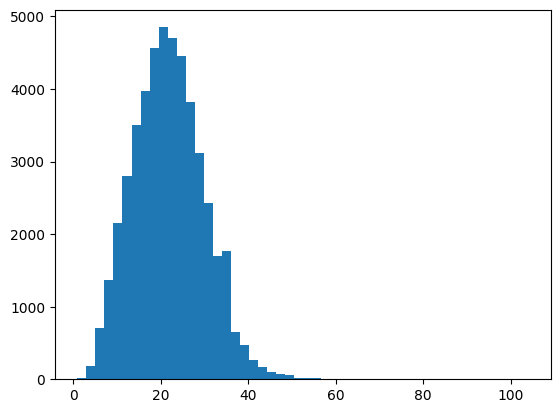

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
X1 = [[word2idx[w[0]] for w in s] for s in sentences]
type(X1[0])
X1[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 10,
 16,
 2,
 17,
 18,
 19,
 20,
 21,
 22]

In [ ]:
max_len = 50

In [ ]:
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)



In [ ]:
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]

In [ ]:
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)


In [ ]:
input_word = layers.Input(shape=(max_len,))
embedding_layer = layers.Embedding(input_dim = num_words,
                                   output_dim = 50,
                                   input_length = max_len)(input_word)
dropout_layer = layers.SpatialDropout1D(0.13)(embedding_layer)
bidirectional_lstm = layers.Bidirectional(layers.LSTM(
    units=250, return_sequences=True,recurrent_dropout=0.13))(dropout_layer)
output = layers.TimeDistributed(
    layers.Dense(num_tags, activation="softmax"))(bidirectional_lstm)
model = Model(input_word, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 500)           602000    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            8517      
 ributed)                                                        
                                                             

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=45,
    epochs=5,
)

Epoch 1/5
853/853 [==============================] - 271s 307ms/step - loss: 0.1830 - accuracy: 0.9567 - val_loss: 0.0691 - val_accuracy: 0.9801
Epoch 2/5
853/853 [==============================] - 250s 293ms/step - loss: 0.0519 - accuracy: 0.9847 - val_loss: 0.0509 - val_accuracy: 0.9850
Epoch 3/5
853/853 [==============================] - 243s 285ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.0479 - val_accuracy: 0.9856
Epoch 4/5
853/853 [==============================] - 243s 285ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0478 - val_accuracy: 0.9858
Epoch 5/5
853/853 [==============================] - 243s 285ms/step - loss: 0.0278 - accuracy: 0.9911 - val_loss: 0.0482 - val_accuracy: 0.9860


Dharshan v - 212222230031


<Axes: >

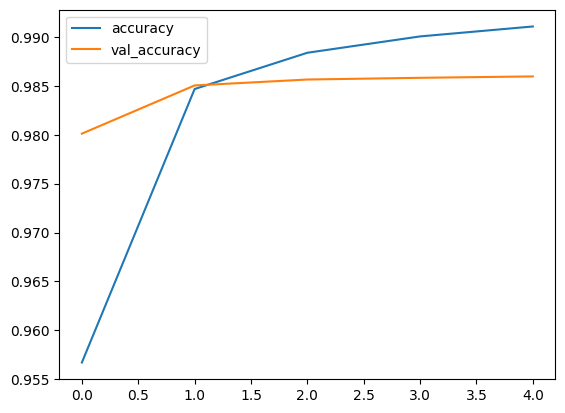

In [21]:
metrics = pd.DataFrame(model.history.history)
metrics.head()
print('Dharshan v - 212222230031')
metrics[['accuracy','val_accuracy']].plot()


dharshan - 212222230031


<Axes: >

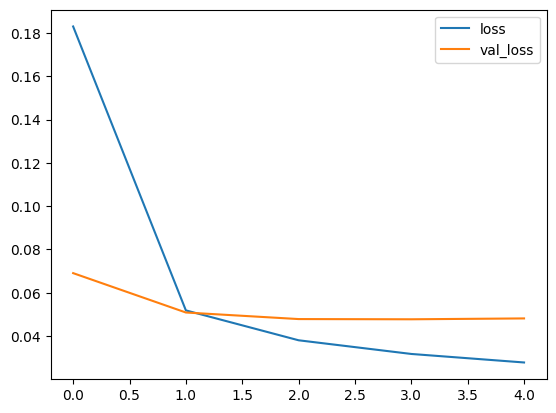

In [22]:
print('dharshan - 212222230031')
metrics[['loss','val_loss']].plot()

In [23]:
i = 20
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 1s/step
Word           True 	 Pred

------------------------------
The            O	O
Bush           B-per	B-per
administration O	O
has            O	O
cited          O	O
the            O	O
material       O	O
as             O	O
evidence       O	O
that           O	O
Iran           B-geo	B-geo
is             O	O
trying         O	O
to             O	O
produce        O	O
highly         O	O
enriched       O	O
uranium        O	O
needed         O	O
for            O	O
nuclear        O	O
weapons        O	O
.              O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
B